In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

D:\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 数据读取

## 1.1 DataLoader

In [ ]:
torch.utils.data.DataLoader(
    dataset,
    batch_size = 1,
    shuffle = False,
    sampler = None,
    batch_sampler = None,
    num_workers = 0,
    collate_fn = None,
    pin_memory = False,
    drop_last = False,
    timeout = 0,
    worker_init_fn = None,
    mutiprocessing_context = None
)

In [ ]:
class Dataset(object):
    def __getitem__(self, index):        ## 接收一个索引，返回一个样本
        raise NotImplementedError
    def __add__(self, other):
        return ConcatDataset([self, other])

In [2]:
"""
# @file name  : 1_split_dataset.py
# @author     : tingsongyu
# @date       : 2019-09-07 10:08:00
# @brief      : 将数据集划分为训练集，验证集，测试集
"""

import os
import random
import shutil


def makedir(new_dir):
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)


if __name__ == '__main__':

    random.seed(1)

    dataset_dir = os.path.join("RMB_data")
    split_dir = os.path.join("data", "rmb_split")
    train_dir = os.path.join(split_dir, "train")
    valid_dir = os.path.join(split_dir, "valid")
    test_dir = os.path.join(split_dir, "test")

    train_pct = 0.8
    valid_pct = 0.1
    test_pct = 0.1

    for root, dirs, files in os.walk(dataset_dir):
        for sub_dir in dirs:

            imgs = os.listdir(os.path.join(root, sub_dir))
            imgs = list(filter(lambda x: x.endswith('.jpg'), imgs))
            random.shuffle(imgs)
            img_count = len(imgs)

            train_point = int(img_count * train_pct)
            valid_point = int(img_count * (train_pct + valid_pct))

            for i in range(img_count):
                if i < train_point:
                    out_dir = os.path.join(train_dir, sub_dir)
                elif i < valid_point:
                    out_dir = os.path.join(valid_dir, sub_dir)
                else:
                    out_dir = os.path.join(test_dir, sub_dir)

                makedir(out_dir)

                target_path = os.path.join(out_dir, imgs[i])
                src_path = os.path.join(dataset_dir, sub_dir, imgs[i])

                shutil.copy(src_path, target_path)

            print('Class:{}, train:{}, valid:{}, test:{}'.format(sub_dir, train_point, valid_point-train_point,
                                                                 img_count-valid_point))

Class:1, train:80, valid:10, test:10
Class:100, train:80, valid:10, test:10


D:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\Anaconda3\envs\pytorch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Training:Epoch[000/010] Iteration[010/010] Loss: 0.6322 Acc:60.00%
Valid:	 Epoch[000/010] Iteration[002/002] Loss: 0.4535 Acc:85.00%
Training:Epoch[001/010] Iteration[010/010] Loss: 0.4557 Acc:84.38%
Valid:	 Epoch[001/010] Iteration[002/002] Loss: 0.3810 Acc:95.00%
Training:Epoch[002/010] Iteration[010/010] Loss: 0.2427 Acc:88.12%
Valid:	 Epoch[002/010] Iteration[002/002] Loss: 0.0376 Acc:100.00%
Training:Epoch[003/010] Iteration[010/010] Loss: 0.0261 Acc:99.38%
Valid:	 Epoch[003/010] Iteration[002/002] Loss: 0.0007 Acc:100.00%
Training:Epoch[004/010] Iteration[010/010] Loss: 0.0062 Acc:100.00%
Valid:	 Epoch[004/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[005/010] Iteration[010/010] Loss: 0.0172 Acc:98.75%
Valid:	 Epoch[005/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[006/010] Iteration[010/010] Loss: 0.0004 Acc:100.00%
Valid:	 Epoch[006/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[007/010] Iteration[010/010] Loss: 0.0010 Acc:10

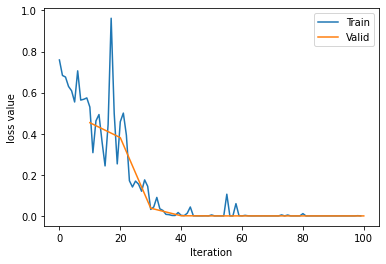

In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from matplotlib import pyplot as plt
from DataLoader_and_Dataset.model.lenet import LeNet
from DataLoader_and_Dataset.tools.my_dataset import RMBDataset


def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


set_seed()  # 设置随机种子
rmb_label = {"1": 0, "100": 1}

# 参数设置
MAX_EPOCH = 10
BATCH_SIZE = 16
LR = 0.01
log_interval = 10
val_interval = 1

# ============================ step 1/5 数据 ============================

split_dir = os.path.join("data", "rmb_split")
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "valid")

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

## transforms
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),         ## 图像缩放
    transforms.RandomCrop(32, padding=4),    ## 图像裁剪
    transforms.ToTensor(),      ## 图像转张量，并完成归一化
    transforms.Normalize(norm_mean, norm_std),    ## 图像数据标准化
])

valid_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

# 构建MyDataset实例
train_data = RMBDataset(data_dir=train_dir, transform=train_transform)
valid_data = RMBDataset(data_dir=valid_dir, transform=valid_transform)

# 构建DataLoder
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE)

# ============================ step 2/5 模型 ============================

net = LeNet(classes=2)
net.initialize_weights()

# ============================ step 3/5 损失函数 ============================
criterion = nn.CrossEntropyLoss()                                                   # 选择损失函数

# ============================ step 4/5 优化器 ============================
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)                        # 选择优化器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)     # 设置学习率下降策略

# ============================ step 5/5 训练 ============================
train_curve = list()
valid_curve = list()

for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.

    net.train()
    for i, data in enumerate(train_loader):

        # forward
        inputs, labels = data
        outputs = net(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

    scheduler.step()  # 更新学习率

    # validate the model
    if (epoch+1) % val_interval == 0:

        correct_val = 0.
        total_val = 0.
        loss_val = 0.
        net.eval()
        with torch.no_grad():
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).squeeze().sum().numpy()

                loss_val += loss.item()

            loss_val_epoch = loss_val / len(valid_loader)
            valid_curve.append(loss_val_epoch)
            # valid_curve.append(loss.item())    # 20191022改，记录整个epoch样本的loss，注意要取平均
            print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, j+1, len(valid_loader), loss_val_epoch, correct_val / total_val))


train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)
valid_x = np.arange(1, len(valid_curve)+1) * train_iters*val_interval # 由于valid中记录的是epochloss，需要对记录点进行转换到iterations
valid_y = valid_curve

plt.plot(train_x, train_y, label='Train')
plt.plot(valid_x, valid_y, label='Valid')

plt.legend(loc='upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()

# ============================ inference ============================

test_dir = os.path.join('data', "test_data")

test_data = RMBDataset(data_dir=test_dir, transform=valid_transform)
valid_loader = DataLoader(dataset=test_data, batch_size=1)

for i, data in enumerate(valid_loader):
    # forward
    inputs, labels = data
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    rmb = 1 if predicted.numpy()[0] == 0 else 100
    print("模型获得{}元".format(rmb))

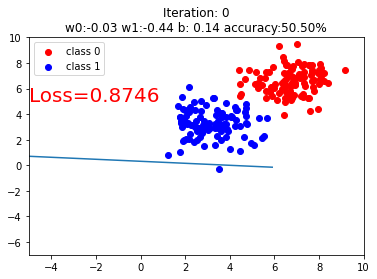

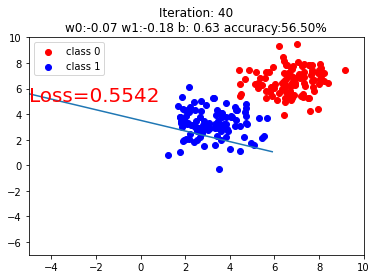

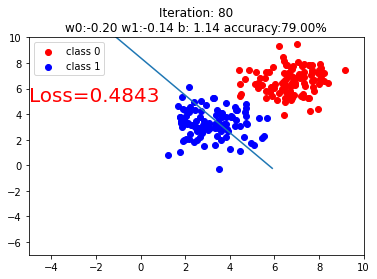

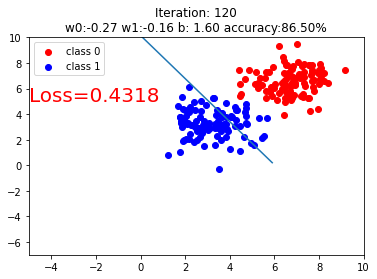

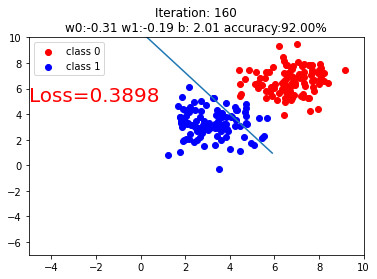

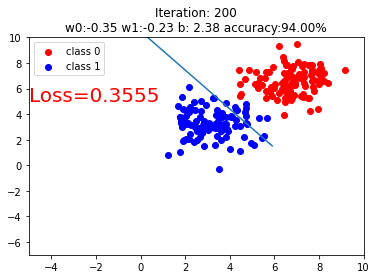

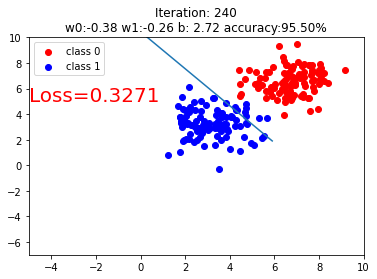

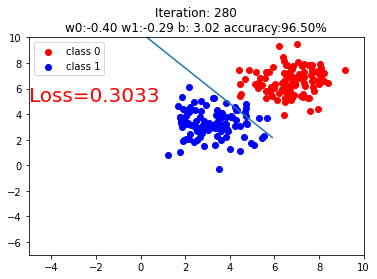

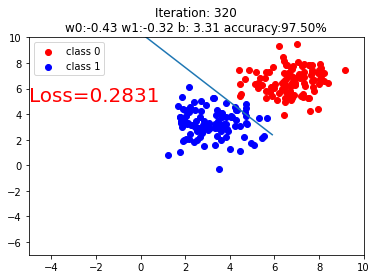

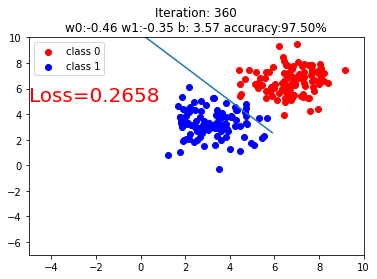

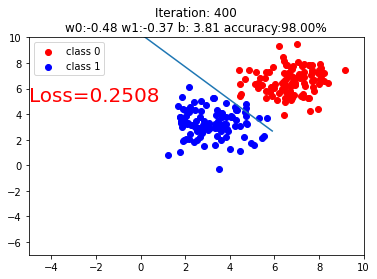

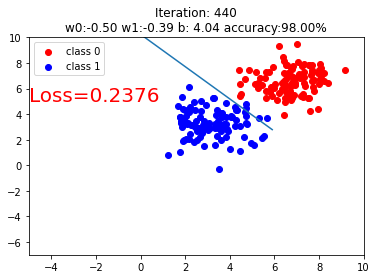

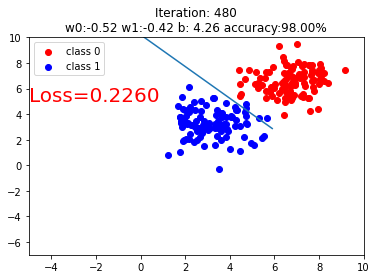

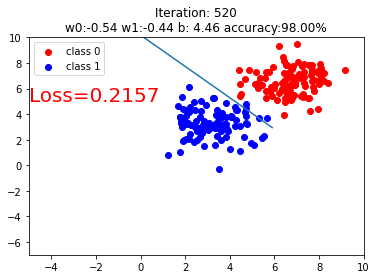

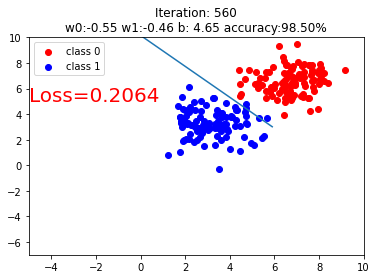

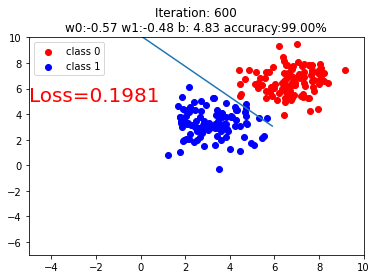

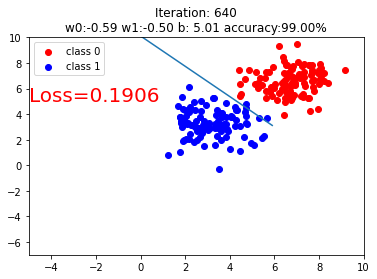

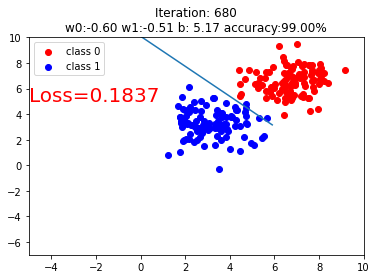

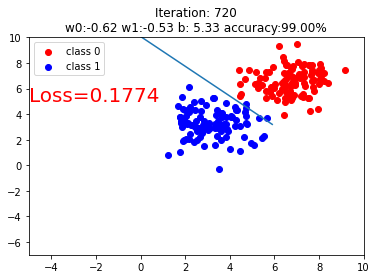

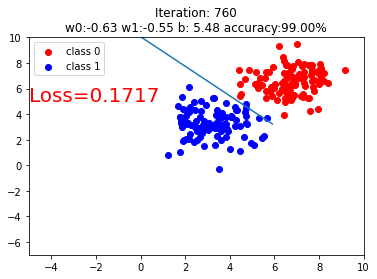

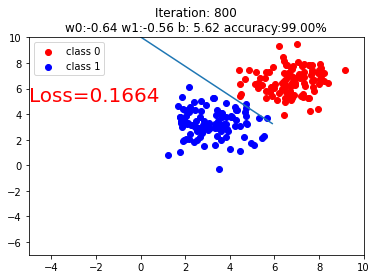

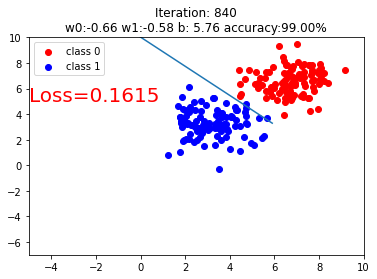

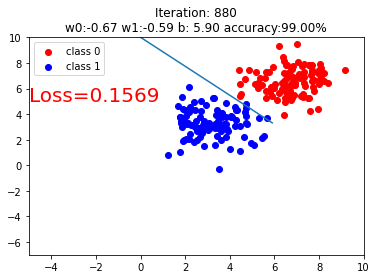

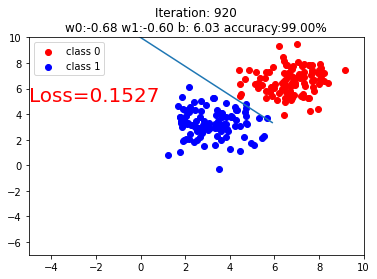

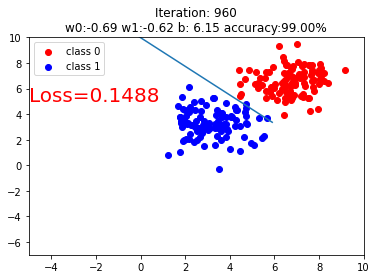

In [9]:
torch.manual_seed(10)

lr = 0.01  # 学习率

# 生成虚拟数据
sample_nums = 100
mean_value = 1.7
bias = 5         # 5
n_data = torch.ones(sample_nums, 2)
x0 = torch.normal(mean_value * n_data, 1) + bias      # 类别0 数据 shape=(100, 2)
y0 = torch.zeros(sample_nums)                         # 类别0 标签 shape=(100, 1)
x1 = torch.normal(-mean_value * n_data, 1) + bias     # 类别1 数据 shape=(100, 2)
y1 = torch.ones(sample_nums)                          # 类别1 标签 shape=(100, 1)
train_x = torch.cat((x0, x1), 0)
train_y = torch.cat((y0, y1), 0)


# 定义模型
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.features = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x


lr_net = LR()

# 定义损失函数与优化器
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(lr_net.parameters(), lr=0.01, momentum=0.9)

for iteration in range(1000):

    # 前向传播
    y_pred = lr_net(train_x)
    y_pred = torch.squeeze(y_pred)

    # 计算 MSE loss
    loss = loss_fn(y_pred, train_y)

    # 反向传播
    loss.backward()

    # 更新参数
    optimizer.step()

    # 清空梯度
    optimizer.zero_grad()

    # 绘图
    if iteration % 40 == 0:

        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()  # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)  # 计算精度

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 10)
        plt.ylim(-7, 10)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()

        plt.show()
        plt.pause(0.5)

        if acc > 0.99:
            break
